In [30]:
import matplotlib.pyplot as plt
import acm.observables.emc as emc
from pathlib import Path
import numpy as np
import torch
plt.style.use(['science','no-latex'])

In [31]:
%matplotlib inline

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [33]:
stat_map = {
    'number_density': emc.GalaxyNumberDensity(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2,]},
        slice_filters={},
    ),
    'wp': emc.GalaxyProjectedCorrelationFunction(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2]},
        slice_filters={}),
    'tpcf': emc.GalaxyCorrelationFunctionMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,], 'multipoles': [0, 2,4]},
        slice_filters={}),
    'pk': emc.GalaxyPowerSpectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'bk': emc.GalaxyBispectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'wst': emc.WaveletScatteringTransform(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'dt_voids': emc.DTVoidGalaxyCorrelationFunctionMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'dsc_pk': emc.DensitySplitPowerSpectrumMultipoles(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
    'minkowski': emc.MinkowskiFunctionals(
        select_filters={'cosmo_idx': [0], 'hod_idx': [30,]}, 
        slice_filters={}),
}

In [34]:

import torch 
import torch.func as func

def get_gradient(statistic):
    fiducial_parameters = stat_map[statistic].lhc_x
    fiducial_parameters = torch.tensor(fiducial_parameters.astype(np.float32), requires_grad=True,).unsqueeze(0)
    def model_fn(x_batch):
        # Add batch dimension for the model
        return stat_map[statistic].model.get_prediction(x_batch)
    return func.jacrev(model_fn)(fiducial_parameters).detach().squeeze().numpy()

def get_full_gradients(statistics):
    return np.vstack([get_gradient(stat) for stat in statistics],)

def get_precision_matrix(full_covariance_vector):
    if full_covariance_vector.shape[1] == 1:
        # For 1D case, calculate variance manually and force a 1x1 matrix
        variance = np.var(full_covariance_vector, ddof=1)
        covariance_matrix = np.array([[variance]])
    else:
        covariance_matrix = np.cov(full_covariance_vector.T)
    correction = stat_map['tpcf'].get_covariance_correction(
        n_s=full_covariance_vector.shape[0],
        n_d=len(covariance_matrix),
        n_theta=20,
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)
    return precision_matrix


def get_fisher_log_det(statistics,):
    full_covariance_vector = np.hstack([stat_map[stat].small_box_y for stat in statistics])
    precision_matrix = get_precision_matrix(full_covariance_vector)
    gradients = get_full_gradients(statistics)
    fisher_matrix = np.dot(gradients.T, np.dot(precision_matrix, gradients))
    sign, fisher_log_det = np.linalg.slogdet(fisher_matrix)
    return fisher_log_det

In [35]:
total_fisher_tpcf = get_fisher_log_det(['tpcf'])

In [36]:
get_fisher_log_det(['tpcf','bk'])

80.1023147188268

In [37]:
get_fisher_log_det(['tpcf','bk', 'dt_voids'])

88.05440219820052

In [38]:

def precompute_derivatives_and_covariance(statistics=['tpcf', 'bk']):
    precomputed = {}
    precomputed['derivatives'] = {}
    for stat_name in statistics:
        precomputed['derivatives'][stat_name] = get_gradient(stat_name)
    
    precomputed['covariance_data'] = {}
    for stat_name in statistics:
        precomputed['covariance_data'][stat_name] = stat_map[stat_name].small_box_y
    
    precomputed['bin_counts'] = {
        stat_name: precomputed['derivatives'][stat_name].shape[1] 
        for stat_name in statistics
    }
    return precomputed

In [57]:
#TODO: Should probably add emulator error to covariance

def greedy_bin_selection(precomputed, max_bins=10,):
    derivatives = precomputed['derivatives']
    covariance_data = precomputed['covariance_data']
    statistics = list(derivatives.keys())
    
    available_bins = {
        stat_name: list(range(derivatives[stat_name].shape[0]))
        for stat_name in statistics
    }
    selected_bins = {stat_name: [] for stat_name in statistics}
    
    current_log_det = float('-inf')
    total_selected_bins = 0
    
    all_bins = []
    for stat_name in statistics:
        for bin_idx in available_bins[stat_name]:
            all_bins.append((stat_name, bin_idx))
    
    print(f"Total bins to evaluate: {len(all_bins)}")
    all_log_dets = []
    
    while total_selected_bins < max_bins and all_bins:
        best_bin = None
        best_log_det = current_log_det
        best_improvement = 0
        
        for i, (stat_name, bin_idx) in enumerate(all_bins):
            temp_selected = {
                stat: selected_bins[stat].copy() for stat in statistics
            }
            temp_selected[stat_name].append(bin_idx)
            
            new_log_det = evaluate_selected_bins_precomputed(
                temp_selected, 
                derivatives, 
                covariance_data
            )
            
            improvement = new_log_det - current_log_det
            if improvement > best_improvement:
                best_improvement = improvement
                best_log_det = new_log_det
                best_bin = i

        
        if best_bin is None or best_improvement < 1e-6:
            print("No significant improvement found, stopping early")
            break
        
        stat_name, bin_idx = all_bins.pop(best_bin)
        selected_bins[stat_name].append(bin_idx)
        total_selected_bins += 1
        current_log_det = best_log_det
        all_log_dets.append(current_log_det)
        
        if total_selected_bins % 5 == 0 or total_selected_bins == max_bins:
            print(f"Selected {total_selected_bins}/{max_bins} bins, current log-det: {current_log_det:.4f}")
            distribution = ", ".join([f"{stat}: {len(bins)}" for stat, bins in selected_bins.items()])
            print(f"Distribution: {distribution}")
    
    return selected_bins, current_log_det, all_log_dets

def evaluate_selected_bins_precomputed(selected_bins, derivatives, covariance_data):

    selected_cov_data = []
    selected_grads = []
    
    for stat_name, bin_indices in selected_bins.items():
        if not bin_indices:
            continue
            
        full_cov_data = covariance_data[stat_name]
        selected_cov_data.append(full_cov_data[:, bin_indices])
        
        full_derivatives = derivatives[stat_name]
        selected_grads.append(full_derivatives[bin_indices,:])
    
    full_covariance_vector = np.hstack(selected_cov_data)
    gradients = np.vstack(selected_grads)
    precision_matrix = get_precision_matrix(full_covariance_vector)
    fisher_matrix = gradients.T @ precision_matrix @ gradients
    
    sign, log_det = np.linalg.slogdet(fisher_matrix)
    if sign <= 0:
        return float('-inf')
    
    return log_det

def run_optimization(statistics=['tpcf', 'bk'], max_bins=100):
    print(f"Precomputing data for statistics: {statistics}")
    precomputed_data = precompute_derivatives_and_covariance(statistics)
    
    print(f"\nRunning greedy selection with max_bins={max_bins}")
    selected_bins, final_log_det, all_log_dets = greedy_bin_selection(precomputed_data, max_bins=max_bins)
    
    print("\nFinal selection:")
    for stat, bins in selected_bins.items():
        print(f"{stat}: {len(bins)} bins selected")
    print(f"Total: {sum(len(bins) for bins in selected_bins.values())} bins")
    print(f"Final log-determinant: {final_log_det:.4f}")
    
    return selected_bins, final_log_det, all_log_dets

In [58]:
selected_bins, final_log_det, all_log_dets = run_optimization(statistics=['tpcf', ], max_bins=10)

Precomputing data for statistics: ['tpcf']

Running greedy selection with max_bins=10
Total bins to evaluate: 150
Selected 5/10 bins, current log-det: -399.7352
Distribution: tpcf: 5
Selected 10/10 bins, current log-det: -240.5022
Distribution: tpcf: 10

Final selection:
tpcf: 10 bins selected
Total: 10 bins
Final log-determinant: -240.5022


In [59]:
len(selected_bins['tpcf'])

10

(30.0, 51.02468536863293)

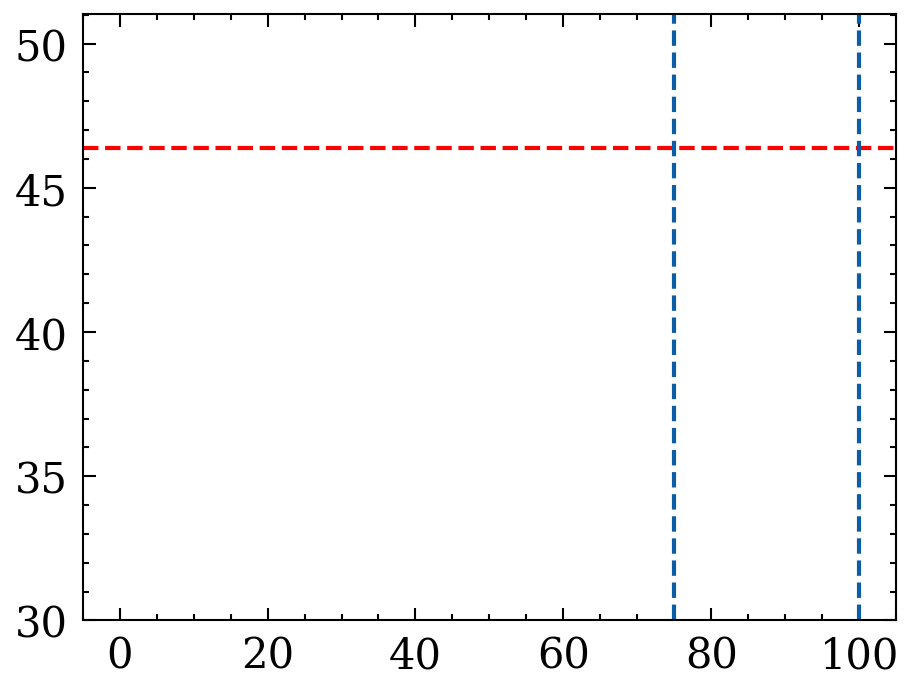

In [60]:
plt.plot(all_log_dets)
plt.axhline(y=total_fisher_tpcf, color='r', linestyle='--', label='Final log-det')
plt.axvline(x=100, linestyle='dashed',)
plt.axvline(x=75, linestyle='dashed',)
plt.ylim(30,total_fisher_tpcf*1.1)

In [22]:
#selected_bins, final_log_det, all_log_dets = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'wp', 'wst',], max_bins=250)

In [23]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk', 'dt_voids', 'minkowski'], max_bins=100)

In [24]:
#selected_bins, final_log_det = run_optimization(statistics=['tpcf', 'bk'], max_bins=100)

In [61]:
from sunbird.inference.pocomc import PocoMCSampler
from sunbird.inference.priors import Yuan23, AbacusSummit
from sunbird import setup_logging

import acm.observables.emc as emc

from pathlib import Path
import numpy as np
import argparse

def get_priors(cosmo=True, hod=True):
    stats_module = 'scipy.stats'
    priors, ranges, labels = {}, {}, {}
    if cosmo:
        priors.update(AbacusSummit(stats_module).priors)
        ranges.update(AbacusSummit(stats_module).ranges)
        labels.update(AbacusSummit(stats_module).labels)
    if hod:
        priors.update(Yuan23(stats_module).priors)
        ranges.update(Yuan23(stats_module).ranges)
        labels.update(Yuan23(stats_module).labels)
    return priors, ranges, labels

In [62]:

from getdist import plots, MCSamples
def get_samples(chain):
    chain['labels']['w0_fld'] = r'w_0'
    chain['labels']['wa_fld'] = r'w_a'
    chain['labels']['omega_cdm'] = r'\omega_{cdm}'
    chain['labels']['sigma8_m'] = r'\sigma_8'
    chain['labels']['n_s'] = r'n_s'
    samples = MCSamples(
        samples=chain['samples'],
        weights=chain['weights'],
        names=chain['names'],
        ranges=chain['ranges'],
        labels=[chain['labels'][n] for n in chain['names']],
    )
    return samples

def run_chain(observable):

    priors, ranges, labels = get_priors(cosmo=True, hod=True)
    fixed_params = ['w0_fld', 'wa_fld', 'nrun', 'N_ur']
    add_emulator_error = True
    cosmo_idx, hod_idx = 0, 30
    observable.select_filters['cosmo_idx'] = cosmo_idx
    observable.select_filters['hod_idx'] = hod_idx

    observable = emc.CombinedObservable([observable])

    data_x = observable.lhc_x
    data_x_names = observable.lhc_x_names
    data_y = observable.lhc_y

    covariance_matrix = observable.get_covariance_matrix(divide_factor=64)
    if add_emulator_error:
        emulator_error = observable.get_emulator_error()
        covariance_matrix += np.diag(emulator_error**2)

    correction = observable.get_covariance_correction(
        n_s=len(observable.small_box_y),
        n_d=len(covariance_matrix),
        n_theta=len(data_x_names) - len(fixed_params),
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)

    fixed_params = {key: data_x[data_x_names.index(key)]
                        for key in fixed_params}


    model = observable.model

    correction = observable.get_covariance_correction(
        n_s=len(observable.small_box_y),
        n_d=len(covariance_matrix),
        n_theta=len(data_x_names) - len(fixed_params),
        method='percival',
    )
    precision_matrix = np.linalg.inv(correction * covariance_matrix)

    fixed_params = {key: data_x[data_x_names.index(key)]
                        for key in fixed_params}


    model = observable.model
    sampler = PocoMCSampler(
        observation=data_y,
        precision_matrix=precision_matrix,
        theory_model=model,
        fixed_parameters=fixed_params,
        priors=priors,
        ranges=ranges,
        labels=labels,
        ellipsoid=True,
    )

    sampler(vectorize=True, n_total=500)

    chain = sampler.get_chain(flat=True)
    names = [param for param in sampler.priors.keys() if param not in sampler.fixed_parameters]
    chain = {**chain,
        'ranges': sampler.ranges,
        'names': names,
        'labels': sampler.labels,
    }
    samples = get_samples(chain)
    markers = {key: data_x[data_x_names.index(key)] for key in data_x_names if key not in fixed_params}
    return chain, samples, markers

In [63]:
from acm.observables.emc.flat.tpcf import GalaxyCorrelationFunctionMultipoles as FlatGalaxyCorrelationFunctionMultipoles

In [64]:
len(selected_bins['tpcf'])

10

In [66]:
fisher_tpcf = FlatGalaxyCorrelationFunctionMultipoles(
    select_filters={
        'cosmo_idx': [0], 
        'hod_idx': [30,], 
        'bin_idx': selected_bins['tpcf'], 
    },
    slice_filters={},

)

In [21]:
chain, samples, markers = run_chain(stat_map['tpcf'])

Iter: 35it [04:06,  7.03s/it, beta=1, calls=88832, ESS=542, logZ=-42.5, logP=-9.86, acc=0.26, steps=9, eff=1]               


Removed no burn in


In [67]:
fisher_chain_10, fisher_samples_10, fisher_markers_10 = run_chain(fisher_tpcf)

Iter: 33it [03:39,  6.64s/it, beta=1, calls=73984, ESS=625, logZ=-29.3, logP=0.39, acc=0.252, steps=8, eff=1]              


Removed no burn in


<Figure size 1260x1134 with 0 Axes>

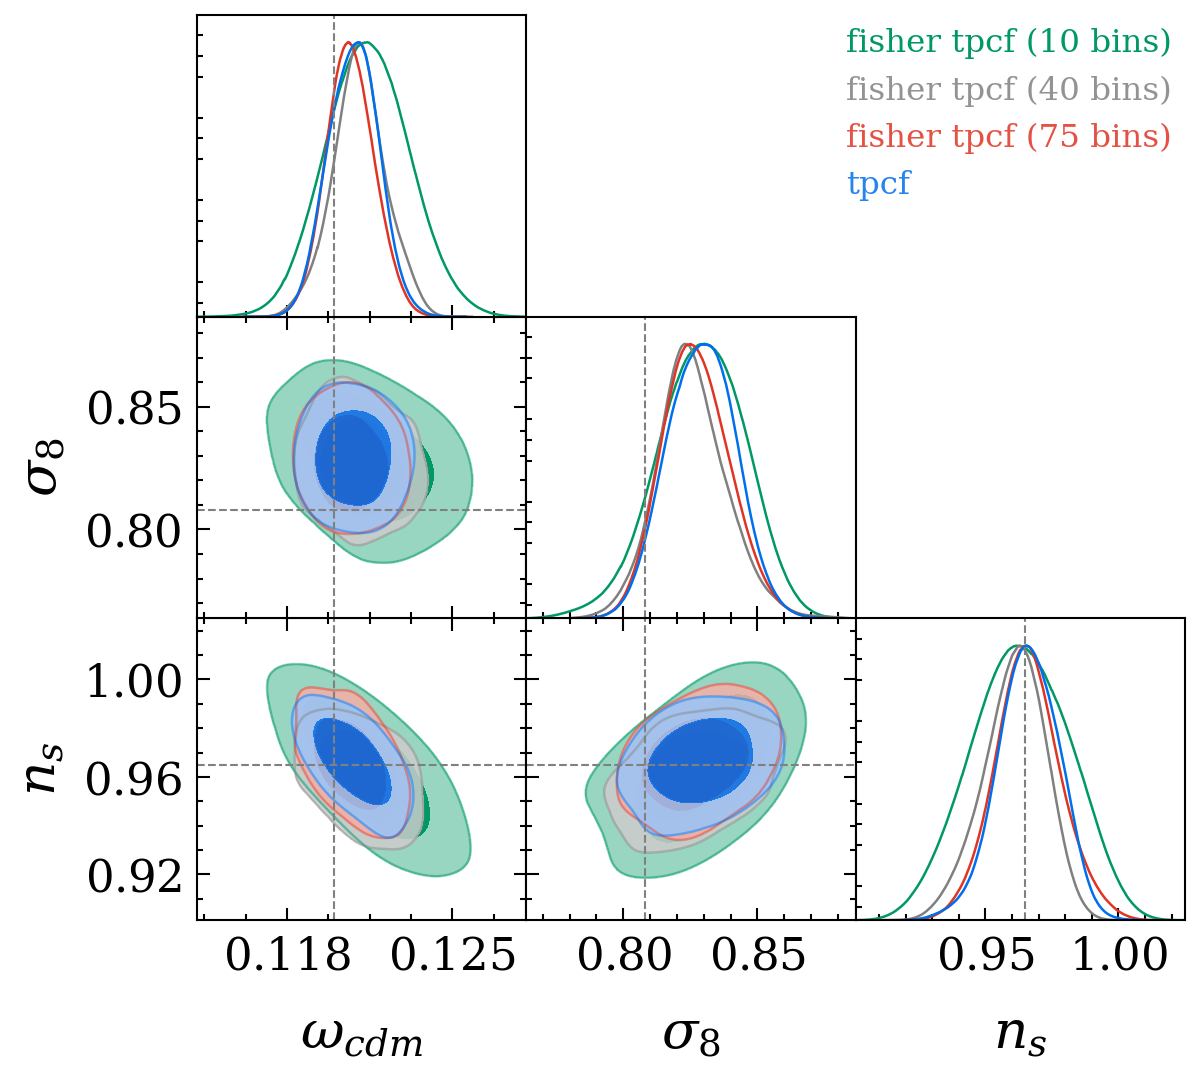

In [68]:

# g = plots.get_single_plotter(width_inch=4)
g = plots.get_single_plotter(width_inch=4.2, ratio=4.5/5)
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = True
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 17

g.triangle_plot(
    roots=[
        fisher_samples_10,
        fisher_samples_40,
        fisher_samples,
        samples,
    ],
    legend_labels=[
        'fisher tpcf (10 bins)', 
        'fisher tpcf (40 bins)', 
        'fisher tpcf (75 bins)', 
        'tpcf', 
    ],
    markers=markers,
    params=['omega_cdm', 'sigma8_m', 'n_s',], 
    filled=True,
)

